
<a id="1"></a>
<div style="text-align: left; background-color: #000000; font-size:100%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;text-align: center; border: 3px solid green;"> 
    <h1>GAN on Face Images</h1>

</div>

<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Table of Content</h1>

</div>


- Project Introduction
- Part 1: Exploratory Data Analysis (EDA)
    - 1.2.1 Load Libraries
    - 1.2.1 Import and Preprocess the dataset
    - 1.2.3 Visualize the  image
    - 1.2.4 Normalize the images
    - 1.2.5 Shuffle the dataset
- Part 2: Build Model 
    - 2.1 Generator Model
    - 2.2 Discriminator Model
    - 2.3 Loss and Optimizer
        - 2.3.1 Discriminator Loss
        - 2.3.1 Generator Loss
        - 2.3.1 Optimizers
- Part 3:  Train
  - 3.1 Defining Training steps
  - 3.2 Generate and save the images
  - 3.3 Train the model
  - 3.4 generate GIF
- References


<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Project Introduction</h2>

</div>





The dataset originates from a Kaggle competition project. As mentioned in the project data card description,this dataset comes from a human faces (https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces). It includes 70,000 images in 128*128 size. As the data is clean and stored from controlled environment hence c;eanup is not required


<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Load libraries</h2>

</div>


In [38]:
import tensorflow as tf

In [2]:
tf.__version__


'2.15.0'

In [39]:
#pip install opencv-python

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from PIL import Image
import cv2

from IPython import display
from sklearn.model_selection import train_test_split



#import cv2
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Import and Preprocess the dataset</h2>

</div>


The data contains thousands of faces images in jpeg format of size 128 * 128. The images are standardized to simplify the image processings.

In [6]:

def load_and_preprocess_images(folder, image_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Add more extensions if needed
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize(image_size)  # Resize image
            img = img.convert('RGB')
            img_array = np.array(img) / 127.5 - 1  # Normalize to [-1, 1]
            #img_array   = np.array(img) / 255.0  # Convert to numpy array and normalize
            images.append(img_array)
            labels.append(filename)  # Replace with actual label extraction logic
    return np.array(images), np.array(labels)

# Load and preprocess images
image_folder = 'faces1'
images, labels = load_and_preprocess_images(image_folder)

# Split into training and testing sets
train_images, test_images, labels_train, labels_test = train_test_split(images, labels, test_size=0.01, random_state=42)

# Display shape of datasets
print(f'Training set shape: {train_images.shape}, {labels_train.shape}')
print(f'Testing set shape: {test_images.shape}, {labels_test.shape}')

print(train_images.shape)
train_images.shape[0]

Training set shape: (11217, 128, 128, 3), (11217,)
Testing set shape: (114, 128, 128, 3), (114,)
(11217, 128, 128, 3)


11217

In [7]:
path = './faces1'
SIZE = 128
_img = []

image_folder = 'faces1'
files = os.listdir(image_folder)




for i in tqdm(files):    
        if i == 'seed9090.png':
            break
        else:  
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

100%|████████████████████████████████████| 11331/11331 [00:16<00:00, 694.31it/s]




<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Visualize the images</h2>

</div>


/var/folders/46/lbbcb42n4xz_pmrf17t8crlc0000gn/T/ipykernel_920/3621347305.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


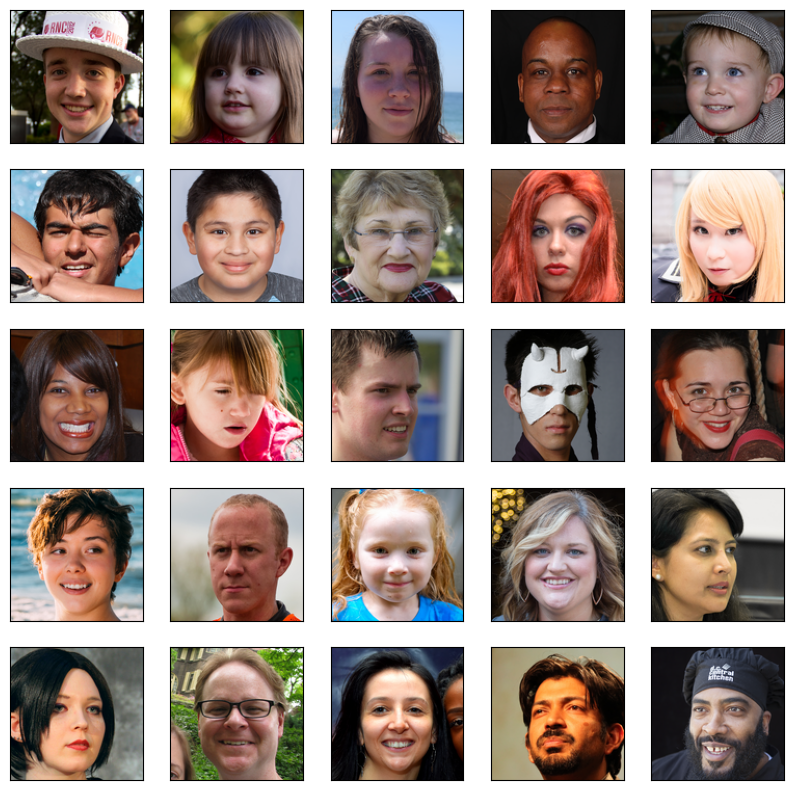

In [8]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(5)



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Normalize the images</h2>

</div>

In [9]:
train_images = train_images.reshape(train_images.shape[0], 128, 128, 3).astype('float32')
#print(f'train_images:{train_images.shape}')
#print(f'train_images:{train_images}')
train_images = (train_images - 127.5) / 127.5  
print(f'train_images:{train_images}')

train_images:[[[[-0.99744713 -0.99689347 -0.9967089 ]
   [-0.9967089  -0.9965859  -0.99640137]
   [-0.9972626  -0.99707806 -0.99689347]
   ...
   [-0.9956017  -0.9955402  -0.99535567]
   [-0.99523264 -0.9947405  -0.9943714 ]
   [-0.9960323  -0.9961553  -0.9955402 ]]

  [[-1.0015686  -1.001384   -1.0014455 ]
   [-1.0007689  -1.0005844  -1.0003998 ]
   [-0.9991696  -0.9989235  -0.99867743]
   ...
   [-0.99523264 -0.9951096  -0.994679  ]
   [-0.99584776 -0.9954787  -0.9951711 ]
   [-0.996955   -0.99707806 -0.9965244 ]]

  [[-1.0024298  -1.0026759  -1.0027989 ]
   [-1.0026144  -1.0029219  -1.0029219 ]
   [-1.0026144  -1.0028604  -1.0027989 ]
   ...
   [-0.99535567 -0.9954787  -0.994925  ]
   [-0.9961553  -0.9961553  -0.99584776]
   [-0.99584776 -0.9956632  -0.99529415]]

  ...

  [[-1.0002768  -1.007351   -1.0065514 ]
   [-0.99886197 -1.0067359  -1.0064284 ]
   [-1.0000308  -1.0058748  -1.0059363 ]
   ...
   [-1.0020608  -1.0029835  -1.0032295 ]
   [-1.0022453  -1.0029835  -1.0036601 ]
   



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Shuffle the dataset</h2>

</div>

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 512

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Generator Model</h1>

</div>

In [12]:
latent_dim = 100
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [13]:
    
generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                        

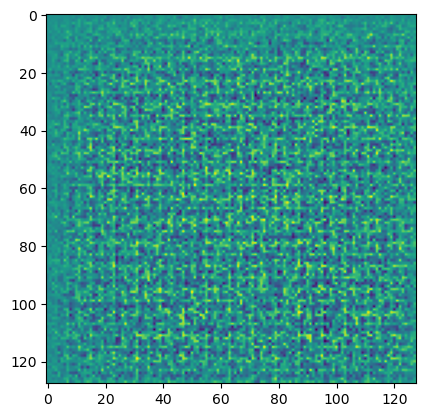

Generated Image Shape : (1, 128, 128, 3)


In [14]:


noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

generated_image = generator(noise, training=False)
print(f'Generated Image Shape : {generated_image.shape}')

<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Discriminator Model</h1>

</div>

In [15]:
def make_discriminator_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4883125]], shape=(1, 1), dtype=float32)



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Loss and Optimizer</h1>

</div>

In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Discriminator Loss</h2>

</div>

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    print (f'Discriminator Total Loss: {total_loss}')
    return total_loss



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Generator Loss</h2>

</div>

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)




<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h2>Optimizers</h2>

</div>

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Save Checkpoint</h1>

</div>

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Define Training Steps</h1>

</div>

In [22]:
EPOCHS = 10
noise_dim = 4000
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_steps(images):
    noise = np.random.normal(0,1,(BATCH_SIZE,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [24]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))
           


    # Generate after the final epoch
   # generate_and_save_images(generator, epochs, seed)



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Generate and save images</h1>

</div>

In [25]:
def generate_and_save_images(model, epoch, test_input, save_dir='images'):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(10, 2))
    
    print(f'predictions.shape[0]: {predictions.shape[0]}')
    plt.figure(figsize=(10, 2))
    for i in range(predictions.shape[0]):
        plt.subplot(1, 5, i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5))
        plt.axis('off')

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    plt.savefig(f'{save_dir}/image_at_epoch_{epoch:04d}.png')
    plt.show()



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Train the model</h1>

</div>

In [26]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 10
NOISE_DIM = 4000
NUM_EXAMPLES_TO_GENERATE = 5

In [27]:
print(f'train_dataset: {train_dataset}')
print(f'EPOCHS: {EPOCHS}')
#train(train_dataset, EPOCHS)

train(EPOCHS,train_dataset)

#train(train_dataset, EPOCHS, BATCH_SIZE, NOISE_DIM, NUM_EXAMPLES_TO_GENERATE)

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

train_dataset: <_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>
EPOCHS: 10

Epoch : 1


/Users/konicapatait/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Discriminator Total Loss: Tensor("add:0", shape=(), dtype=float32)
Discriminator Total Loss: Tensor("add:0", shape=(), dtype=float32)
Discriminator Total Loss: Tensor("add:0", shape=(), dtype=float32)
 Time:10108.0
Generator Loss: 9.736150730077497e-08 Discriminator Loss: 9.736150730077497e-08

Epoch : 2
 Time:13303.0
Generator Loss: 1.3848234559077355e-08 Discriminator Loss: 1.3848234559077355e-08

Epoch : 3
 Time:14741.0
Generator Loss: 1.061221066578355e-08 Discriminator Loss: 1.061221066578355e-08

Epoch : 4
 Time:10485.0
Generator Loss: 1.0229845415210548e-08 Discriminator Loss: 1.0229845415210548e-08

Epoch : 5
 Time:17707.0
Generator Loss: 1.0123832439035141e-08 Discriminator Loss: 1.0123832439035141e-08

Epoch : 6
 Time:13418.0
Generator Loss: 1.0064958644306898e-08 Discriminator Loss: 1.0064958644306898e-08

Epoch : 7
 Time:8036.0
Generator Loss: 1.0007126682864964e-08 Discriminator Loss: 1.0007126682864964e-08

Epoch : 8
 Time:2779.0
Generator Loss: 9.953366131298935e-09 Disc


<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:80%; font-family: Comic Sans MS; padding: 5px;border-radius:10px 10px; color: white;"> 
    <h1>Create a GIF</h1>

</div>

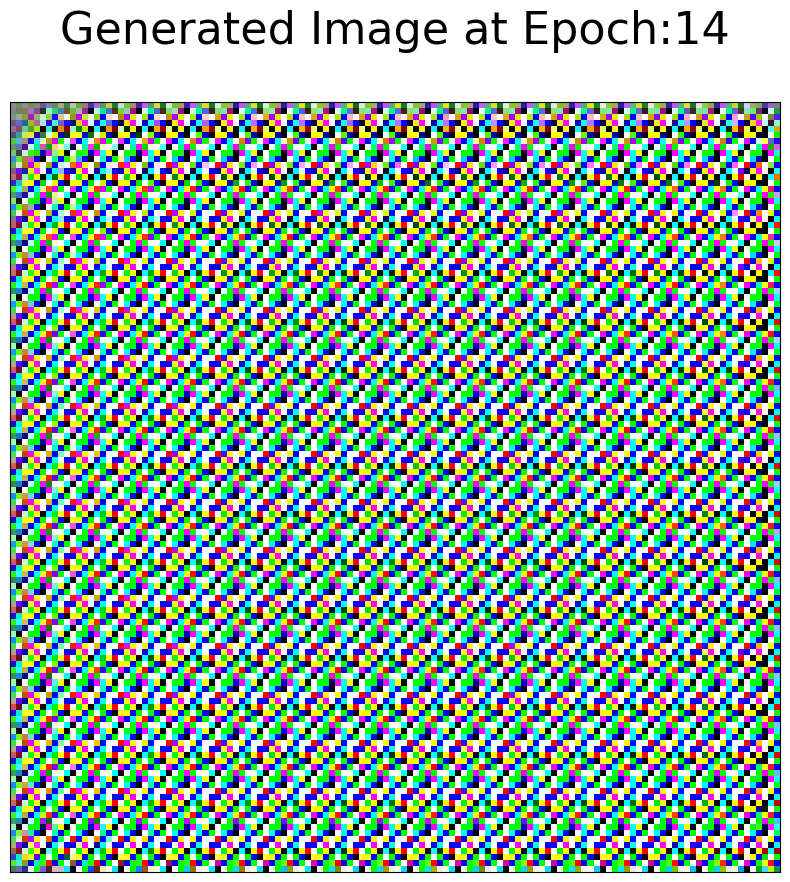

In [28]:
def plot_generated_images(square = 5, epochs = 14):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

plot_generated_images(1)

In [29]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


In [31]:
display_image(4)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0004.png'

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)



<a id="1"></a>
<div style="text-align: left; background-color: #964B00; font-size:60%; font-family: Comic Sans MS; padding: 5px;border-radius:5px 5px; color: white;"> 
    <h1>References:</h1>

</div>


https://www.kaggle.com/code/theblackmamba31/generating-fake-faces-using-gan/notebook

https://www.kaggle.com/code/tusharpatil98/face-gan-using-pytorch/input?select=real_vs_fake

https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
